# Цель работы

У нас есть логи посетителей интернет магазина. <br> 
Наша задача - преобразовать их в удобный вид, поместить в базу данных и создать по ним дашборд с основными показателями этого магазина. <br> Поднимать базу данных будем с помощью докера <br>
База данных: Clickhouse <br>
BI-система : Yandex Datalens <br>
Итоговый дашборд доступен по [ссылке](https://datalens.yandex/kh78hvzugxxw8)

## Содержание:
1. [Docker](#1)
1. [Подготовка данных](#2)
    1. [Структура БД](#2_1)
    1. [Парсинг](#2_2)
1. [Предобработка](#3)
    1. [Users](#3_1)
    1. [Products](#3_2)
    1. [User_actions](#3_3)
    1. [Orders](#3_4)
1. [Работа с БД](#4)
1. [Datalens](#5)
    1. [Настройка окружения](#3_1)
    1. [Дашборд](#3_2)



# Docker <a class="anchor" id="1"></a>

Для реализации проекта нам потребуется три 3 образа: jupyter-notebook, clickhouse и datalens <br>
Начнем с первых двух. Поднимать кликхаус и юпитер будем через docker-compose файл где и пропишем все основные параметры

Начнем с кликхауса

```docker
clickhouse:
    image: yandex/clickhouse-server
    restart: always
    container_name: clickhouse-server
    volumes:
      - data_dir:/var/lib/clickhouse
      - ./config.xml:/etc/clickhouse-server/config.d/config.xml # Файл конфигурации
    environment:
      CLICKHOUSE_USER: igor
      CLICKHOUSE_PASSWORD: secret
    ulimits:
      nofile: 262144 
    networks:
      - datalens_default
```

Тут мы прописываем само имя нашего контейнетра, путь к волюмам где будут храниться наши данные, а также параметры окружения в виде имени пользователя и пароля. Также все наши образы будут поключены к одной сети datalens_default, чтобы в будущем не было проблем с их взаимодействием

С юпитер ноутбуком ситуация похожая

 ```docker
 jupyter:
    container_name: my_notebook
    ports:
      - "8888:8888"
    volumes:
      - .:/home/jovyan/
    build:
      context: .
      dockerfile: Dockerfile
    environment:
    - JUPYTER_TOKEN=easy
    networks:
      - datalens_default
 ```

Только мы еще подключили порт для соединения + сам образ будет подниматься из отдельного докерфайла такого содержания:

```docker
FROM jupyter/datascience-notebook:r-4.0.3
RUN pip3 install clickhouse-connect
RUN export JUPYTER_RUNTIME_DIR="./.jupyter_runtime"
```

Тут мы дополнительно прописали команду  для установки нужной библиотеки для подключения к кликхаусу и команду для избежания некоторых ошибок

Пока с докером все, прописываем команду "docker-compose up -d" и идем обрабатывать данные

# Предобработка данных <a class="anchor" id="2"></a>

## Структура БД <a class="anchor" id="2_1"></a>

In [112]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import clickhouse_connect
import numpy as np

In [113]:
df = pd.read_csv('raw_logs.csv')

In [114]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,accessed_Ffom,age,gender,country,membership,returned,pay_method,order_id
0,2020-09-24 11:57:06 UTC,view,1996170,8452715,electronics.telephone,NaN,31.90,3034812,Chrome,23,Male,US,Premium,No,Cash,0
1,2020-10-23 05:30:06 UTC,view,1785245,1480748,stationery.cartrige,canon,43.11,3034812,Chrome,23,Male,US,Premium,No,Cash,0
2,2020-12-12 16:13:11 UTC,cart,1443968,9479855,electronics.telephone,sirius,9.83,3034812,Chrome,23,Male,US,Premium,No,Cash,0
3,2021-01-29 22:43:00 UTC,view,4079061,7789416,computers.components.videocards,powercolor,399.48,3034812,Chrome,23,Male,US,Premium,No,Cash,0
4,2020-09-24 11:57:26 UTC,view,139905,2472027,computers.components.cooler,zalman,17.16,8870078,Chrome,52,Male,CN,Normal,No,Others,0


Посмотрим на количество данных

In [115]:
df.shape

(903103, 16)

Немало, для удобства разделим все данные на таблицы по следующей схеме

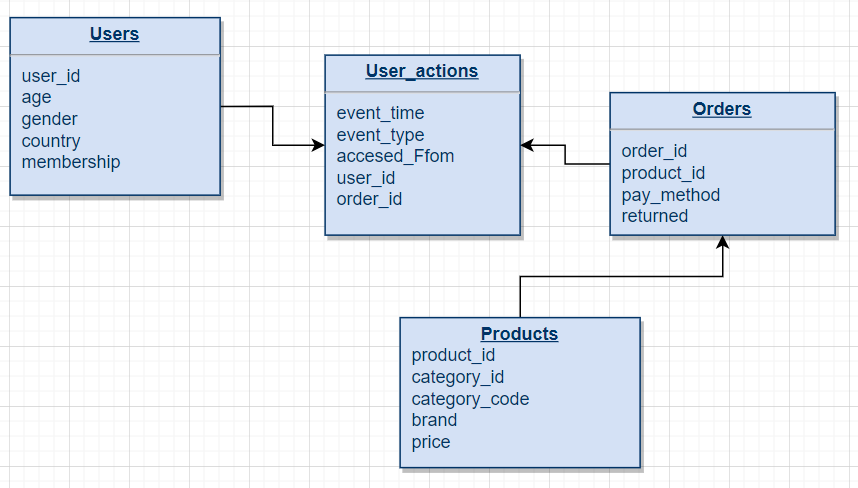

Сейчас ее и реализуем. <br>
Начнем с таблицы users

In [116]:
users = df.loc[:,['user_id','age','gender','country','membership']]

Удалим возможные дубликаты

In [117]:
users.drop_duplicates(subset='user_id',inplace=True)

In [118]:
users.user_id.nunique()

230341

In [119]:
users.shape

(230341, 5)

Отлично, посмотрим что получилось

In [120]:
users.head()

,user_id,age,gender,country,membership
0,3034812,23,Male,US,Premium
4,8870078,52,Male,CN,Normal
8,1376091,NaN,Unknown,US,Premium
14,1075108,NaN,Female,CH,Premium
20,7170390,NaN,Female,US,Premium


Так, тут есть проблема, страны названы не совсем понятными аббревиатурами. В следующем пункте исправим это, а пока идем дальше

In [121]:
orders = df.loc[:,['order_id','product_id','pay_method','returned']]

In [122]:
df.order_id.value_counts()

0          865007
3173459         1
3173730         1
3173927         1
3174044         1
            ...  
1582853         1
1582922         1
1583032         1
1583114         1
4753923         1
Name: order_id, Length: 38097, dtype: int64

Видимо нули это действия где не был совершен заказ, стоит их убрать

In [123]:
orders = orders[orders['order_id']!=0]

Тоже самое делаем с products

In [124]:
products = df.loc[:,['product_id','category_id','category_code','brand','price']]

In [125]:
products.drop_duplicates(subset='product_id',inplace=True)

Осталась только таблица с действиями, чтобы создать ее просто удалим из основного датафрейма лишние столбцы

In [126]:
user_actions = df.drop(columns = ['product_id','category_id','category_code',
                   'brand','price','age','gender','country',
                   'membership','pay_method','returned']).copy()

In [127]:
user_actions.head()

,event_time,event_type,user_id,accessed_Ffom,order_id
0,2020-09-24 11:57:06 UTC,view,3034812,Chrome,0
1,2020-10-23 05:30:06 UTC,view,3034812,Chrome,0
2,2020-12-12 16:13:11 UTC,cart,3034812,Chrome,0
3,2021-01-29 22:43:00 UTC,view,3034812,Chrome,0
4,2020-09-24 11:57:26 UTC,view,8870078,Chrome,0


In [128]:
orders.order_id.value_counts()

1070       1
3173459    1
3173730    1
3173927    1
3174044    1
          ..
1582853    1
1582922    1
1583032    1
1583114    1
4753923    1
Name: order_id, Length: 38096, dtype: int64

## Парсинг <a class="anchor" id="2_2"></a>

Чтобы заменить аббревиатуры стран в таблице users на полные названия нужно спарсить из интернета полную таблицу с сокращениями. <br>
Для этого будем использовать библиотеки requests и BeatifulSoup


In [129]:
url = 'https://www.artlebedev.ru/country-list/' # возьмем эту таблицу с сайта студии Артемия Лебедева
r = requests.get(url) # делаем запрос к сайту
soup = BeautifulSoup(r.text,'html.parser') # достаем весь html код

In [130]:
table = soup.find('table') # находим тэг таблицы

Названия стран и аббревиатур находятся в тегах td, чтобы их достать нам нужно выбирать эти теги с нужным интервалом

In [131]:
countr = table.find_all('td')[2::8]

In [132]:
abbr = table.find_all('td')[3::8]

In [133]:
countr[0], abbr[0]

(<td>Abkhazia</td>, <td>AB</td>)

Отлично, все получилось, осталось только избавится он лишних знаков

In [134]:
str(countr[0]).split('<')[1].split('>')[1]

'Abkhazia'

In [135]:
str(abbr[0]).split('<')[1].split('>')[1]

'AB'

Будем помещать очищенные знаки в отдельные массивы

In [136]:
col1 = [0 for _ in range(len(countr))]
col2 = [0 for _ in range(len(countr))]
for i in range(len(countr)):
    c = str(countr[i]).split('<')[1].split('>')[1]
    a = str(abbr[i]).split('<')[1].split('>')[1]
    col1[i] = c
    col2[i] = a

In [137]:
col1[:4],col2[:4]

(['Abkhazia', 'Australia', 'Austria', 'Azerbaijan'], ['AB', 'AU', 'AT', 'AZ'])

Теперь поместим полученные данные в датафрейм и соединим его с основной таблицей users

In [138]:
df_ab = pd.DataFrame({'Full_name':col1,'country':col2})

In [139]:
df_ab.head()

,Full_name,country
0,Abkhazia,AB
1,Australia,AU
2,Austria,AT
3,Azerbaijan,AZ
4,Albania,AL


In [140]:
was = users.shape[0]

In [141]:
users = users.merge(df_ab,on='country')
users.head()

,user_id,age,gender,country,membership,Full_name
0,3034812,23,Male,US,Premium,United States
1,1376091,NaN,Unknown,US,Premium,United States
2,7170390,NaN,Female,US,Premium,United States
3,3061938,NaN,Female,US,Premium,United States
4,547325,NaN,Female,US,Normal,United States


In [142]:
users['country'] = users['Full_name']
users.drop(columns='Full_name',inplace=True)

Проверим что у нас никакие данные не потерялись

In [143]:
was, users.shape[0]

(230341, 230341)

Теперь, когда у нас данные в удобном формате, мы можем приступить к их форматированию.

# Предобработка <a class="anchor" id="3"></a>

Начнем как раз с таблицы users

## Users <a class="anchor" id="3_1"></a> 

In [144]:
users.head()

,user_id,age,gender,country,membership
0,3034812,23,Male,United States,Premium
1,1376091,NaN,Unknown,United States,Premium
2,7170390,NaN,Female,United States,Premium
3,3061938,NaN,Female,United States,Premium
4,547325,NaN,Female,United States,Normal


Видно что в возрасте много пропуском, посмотрим какие типы у наших переменных

In [145]:
users.dtypes

user_id        int64
age           object
gender        object
country       object
membership    object
dtype: object

Возраст почему-то object, посмотрим какие там есть значения

In [146]:
users.age.value_counts().head(10)

--    19651
37     2460
22     2382
43     2335
64     2309
40     2292
67     2276
26     2265
61     2264
30     2239
Name: age, dtype: int64

Понятно. Заменим все строки на медиану возраста, для начала посчитаем ее

In [147]:
arr = [] # будем сюа добавлять все числовые значения
for i in users.age.dropna().values:
    try:
        arr.append(int(i)) # пытаемся перевести значение в число
    except: # если не получается пропускаем его
        pass
med = int(np.median(arr))

Теперь напишем функцию которая будет делать почти тоже самое, но если возникла ошибка она будет возвращать медиану. Так мы избавимся и от пропусков, и от строк

In [148]:
def check(x):
    try:
        return int(x)
    except:
        return med
users['age'] = users.age.apply(check)

Проверим результат

In [149]:
users.isna().sum()

user_id       0
age           0
gender        0
country       0
membership    0
dtype: int64

In [150]:
users.dtypes

user_id        int64
age            int64
gender        object
country       object
membership    object
dtype: object

Прекрасно, все сработало <br>
Перейдем к таблице products

## Products <a class="anchor" id="3_2"></a>

Действуем по той же схеме

In [151]:
products.dtypes

product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
dtype: object

Тут все нормально

In [152]:
products.isna().sum()

product_id           0
category_id          0
category_code    18856
brand            16486
price                0
dtype: int64

Пропуски в брендах и категориях заменим на 'Unknown'

In [153]:
products.category_code.fillna('Unknown',inplace=True)
products.brand.fillna('Unknown',inplace=True)

In [43]:
products.head()

,product_id,category_id,category_code,brand,price
0,1996170,8452715,electronics.telephone,Unknown,31.90
1,1785245,1480748,stationery.cartrige,canon,43.11
2,1443968,9479855,electronics.telephone,sirius,9.83
3,4079061,7789416,computers.components.videocards,powercolor,399.48
4,139905,2472027,computers.components.cooler,zalman,17.16


Приведем колонку category_code в более удобный вид

In [154]:
products[['category_level_1','category_level_2', # разделим колонку по точкам на 4 отдельных колонки
     'category_level_3','category_level_4']] = products.category_code.str.split('.',expand=True).add_prefix('category_level_') 

In [155]:
products.drop(columns='category_code',inplace = True) # этот столбец нам не понадобится

In [156]:
products.isna().sum()

product_id              0
category_id             0
brand                   0
price                   0
category_level_1        0
category_level_2    18856
category_level_3    35057
category_level_4    53417
dtype: int64

Заменим получившиеся пропуски на 'Not'

In [158]:
products['category_level_2'].fillna('Not',inplace=True)
products['category_level_3'].fillna('Not',inplace=True)
products['category_level_4'].fillna('Not',inplace=True)

In [159]:
products.isna().sum()

product_id          0
category_id         0
brand               0
price               0
category_level_1    0
category_level_2    0
category_level_3    0
category_level_4    0
dtype: int64

In [51]:
products.head()

,product_id,category_id,category_code,brand,price,category_level_1,category_level_2,category_level_3,category_level_4
0,1996170,8452715,electronics.telephone,Unknown,31.90,electronics,telephone,Not,Not
1,1785245,1480748,stationery.cartrige,canon,43.11,stationery,cartrige,Not,Not
2,1443968,9479855,electronics.telephone,sirius,9.83,electronics,telephone,Not,Not
3,4079061,7789416,computers.components.videocards,powercolor,399.48,computers,components,videocards,Not
4,139905,2472027,computers.components.cooler,zalman,17.16,computers,components,cooler,Not


## User_actions <a class="anchor" id="3_3"></a>

In [160]:
user_actions.head()

,event_time,event_type,user_id,accessed_Ffom,order_id
0,2020-09-24 11:57:06 UTC,view,3034812,Chrome,0
1,2020-10-23 05:30:06 UTC,view,3034812,Chrome,0
2,2020-12-12 16:13:11 UTC,cart,3034812,Chrome,0
3,2021-01-29 22:43:00 UTC,view,3034812,Chrome,0
4,2020-09-24 11:57:26 UTC,view,8870078,Chrome,0


Сократим event_time просто до даты

In [161]:
user_actions.event_time=pd.to_datetime(df.event_time.apply(lambda x: x[:10]))

In [162]:
user_actions.dtypes

event_time       datetime64[ns]
event_type               object
user_id                   int64
accessed_Ffom            object
order_id                  int64
dtype: object

C типами данных все нормально

In [164]:
user_actions.head()

,event_time,event_type,user_id,accessed_Ffom,order_id
0,2020-09-24,view,3034812,Chrome,0
1,2020-10-23,view,3034812,Chrome,0
2,2020-12-12,cart,3034812,Chrome,0
3,2021-01-29,view,3034812,Chrome,0
4,2020-09-24,view,8870078,Chrome,0


## Orders <a class="anchor" id="3_4"></a>

In [167]:
orders.dtypes

order_id       int64
product_id     int64
pay_method    object
returned      object
dtype: object

In [168]:
orders.isna().sum()

order_id      0
product_id    0
pay_method    0
returned      0
dtype: int64

Тут тоже все нормально, теперь перейдем к работе уже с кликхаусом

# Работа с БД <a class="anchor" id="4"></a>

Подключаемся к бд с помощью clickhouse_connect, вводим параметры которые задавали изначально в докере

In [62]:
client = clickhouse_connect.get_client(host='clickhouse-server', port='8123', user='igor', password= 'secret')

Посмотрим проходят ли наши команды, создадим новую бд

In [63]:
database = 'CREATE DATABASE IF NOT EXISTS my_db'
client.command(database)

Отлично, работает. Создадим нашу первую таблицу

In [176]:
users.head()

,user_id,age,gender,country,membership
0,3034812,23,Male,United States,Premium
1,1376091,43,Unknown,United States,Premium
2,7170390,43,Female,United States,Premium
3,3061938,43,Female,United States,Premium
4,547325,43,Female,United States,Normal


In [64]:
client.command('DROP TABLE IF EXISTS my_db.users')
create_table_sql = '''
CREATE TABLE my_db.users (
user_id BIGINT,
age BIGINT, 
gender String, 
country String, 
membership String
) ENGINE = MergeTree()
ORDER BY (user_id)
'''

In [66]:
client.command(create_table_sql)
client.insert_df('my_db.users',users)

Проверим, проходят ли на запросы

In [67]:
result_df = client.query_df('SELECT * FROM my_db.users')
result_df

,user_id,age,gender,country,membership
0,4,0,Female,United States,Premium
1,24,22,Female,Russian Federation,Premium
2,42,65,Male,Italy,Premium
3,155,0,Female,Italy,Premium
4,166,43,Female,Italy,Premium
...,...,...,...,...,...
230336,9999868,0,Female,Italy,Premium
230337,9999869,45,Male,Italy,Premium
230338,9999913,26,Female,Switzerland,Normal
230339,9999924,64,Female,Italy,Normal


Прекрасно, аналогично вставляем остальные таблицы

In [68]:
orders.head()

,order_id,product_id,pay_method,returned
46,1070,1821557,Credit Card,No
48,1241,3738555,Credit Card,No
56,1438,1715916,Cash,No
58,1601,1745899,Debit Card,No
155,1751,809948,Others,No


In [69]:
client.command('DROP TABLE IF EXISTS my_db.orders')
create_table_sql = '''
CREATE TABLE my_db.orders (
order_id BIGINT, 
product_id BIGINT,
pay_method String, 
returned String
) ENGINE = MergeTree()
ORDER BY (order_id)
'''

In [70]:
client.command(create_table_sql)
client.insert_df('my_db.orders',orders)

In [71]:
user_actions.head()

,event_time,event_type,user_id,accessed_Ffom,order_id
0,2020-09-24,view,3034812,Chrome,0
1,2020-10-23,view,3034812,Chrome,0
2,2020-12-12,cart,3034812,Chrome,0
3,2021-01-29,view,3034812,Chrome,0
4,2020-09-24,view,8870078,Chrome,0


In [72]:
client.command('DROP TABLE IF EXISTS my_db.user_actions')
create_table_sql = '''
CREATE TABLE my_db.logs (
event_time DATETIME,
event_type String,
user_id BIGINT,
accessed_Ffom String,
order_id BIGINT
) ENGINE = MergeTree()
ORDER BY (event_time)
'''

In [73]:
client.command(create_table_sql)
client.insert_df('my_db.user_actions',user_actions)

In [82]:
client.command('DROP TABLE IF EXISTS my_db.products')
create_table_sql = '''
CREATE TABLE my_db.products (
product_id Int64,
category_id Int64, 
brand String,
price Float32,
category_level_1 String,
category_level_2 String,
category_level_3 String,
category_level_4 String
) ENGINE = MergeTree()
ORDER BY (product_id)
'''

In [83]:
client.command(create_table_sql)
client.insert_df('my_db.products',products)

In [102]:
orders.head()

,order_id,product_id,pay_method,returned
46,1070,1821557,Credit Card,No
48,1241,3738555,Credit Card,No
56,1438,1715916,Cash,No
58,1601,1745899,Debit Card,No
155,1751,809948,Others,No


Сделаем запрос, чтобы проверить как рабают связи между таблицами

In [115]:
query = '''
SELECT event_time::date as date, COUNT(order_id) FILTER (WHERE returned='No') as orders
FROM my_db.logs JOIN my_db.orders 
USING(order_id)
GROUP BY event_time::date
'''

In [116]:
result_df = client.query_df(query)
result_df.head()

,date,orders
0,2020-09-24,81
1,2020-09-25,149
2,2020-09-26,123
3,2020-09-27,111
4,2020-09-28,189


Работает

# Datalens <a class="anchor" id="5"></a>

## Настройка окружения <a class="anchor" id="5_1"></a>

Теперя запустим сам Datalens, для нужно будет поднять уже его docker compose с помощью следующих команд

```docker 
cd datalens | спускаемся в папку даталенса
docker compose up -d | запускаем файл в пассивном режиме
```




Теперь по этому адресу http://localhost:8080 у нас должен открыться даталенс, сейча это и проверим

<img src="screens/workbook.png" width=1000 />

Все хорошо, проверим как работает наше подключение к кликхаусу

<img src="screens/connect.png" width=500 />

Теперь создадим датасет, где свяжем все наши таблицы

<img src="screens/dataset.png" width=1000 />

Попробуем построить первый чарт

<img src="screens/chart.png" width=1000 />

Теперь, когда настройка закончена, можно переходить непосредственно к построению дашборда

## Дашборд <a class="anchor" id="5_2"></a>

Целью дашборда была визуализация основных показателей магазина <br>
В качестве ключевых метрик было решено выбрать: 
- общая выручка и по сегментам пользователей
- процент клиентов разного статуса и их количество по дням
- количество заказов
- средний чек
- обьем выручки по источникам трафика
- процент конверсии и его динамика
- процент возвратов и его динамика
- показатели выручки и количества заказов для каждой категории и бренда


Итоговый результат можно посмотреть по [ссылке](https://datalens.yandex/kh78hvzugxxw8)